<a href="https://colab.research.google.com/github/BhargavKilambi/sem-7/blob/master/proposed_with_aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This is an implementation of CRNN over audio data ( 2sec snippets downsampled to mono (22050Hz)) with augmentation of data (adding noise)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp "drive/My Drive/AudPrep.zip" "AudPrep.zip"

In [0]:
!unzip "AudPrep.zip"

Archive:  AudPrep.zip
   creating: AudPrep/
   creating: AudPrep/cel/
  inflating: AudPrep/cel/008__[cel][nod][cla]0058__1.wav.npy  
  inflating: AudPrep/cel/008__[cel][nod][cla]0058__2.wav.npy  
  inflating: AudPrep/cel/008__[cel][nod][cla]0058__3.wav.npy  
  inflating: AudPrep/cel/012__[cel][nod][cla]0043__1.wav.npy  
  inflating: AudPrep/cel/012__[cel][nod][cla]0043__2.wav.npy  
  inflating: AudPrep/cel/012__[cel][nod][cla]0043__3.wav.npy  
  inflating: AudPrep/cel/013__[cel][nod][cla]0025__1.wav.npy  
  inflating: AudPrep/cel/013__[cel][nod][cla]0025__2.wav.npy  
  inflating: AudPrep/cel/013__[cel][nod][cla]0025__3.wav.npy  
  inflating: AudPrep/cel/014__[cel][nod][cla]0041__1.wav.npy  
  inflating: AudPrep/cel/014__[cel][nod][cla]0041__2.wav.npy  
  inflating: AudPrep/cel/014__[cel][nod][cla]0041__3.wav.npy  
  inflating: AudPrep/cel/027__[cel][nod][cla]0027__1.wav.npy  
  inflating: AudPrep/cel/027__[cel][nod][cla]0027__2.wav.npy  
  inflating: AudPrep/cel/027__[cel][nod][cla]002

In [0]:
import numpy as np
import os
import matplotlib.pyplot as plt
from os.path import isfile

In [0]:
from keras.layers import Conv2D,MaxPooling2D,Dropout,BatchNormalization,Dense,Activation,Flatten,GlobalMaxPooling2D,Reshape,TimeDistributed,LSTM,Permute
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.regularizers import l2

Using TensorFlow backend.


In [0]:
mono=True

# Get and return all the sub dir names ( == classes)
def get_class_names(path="AudPrep/"): 
    class_names = os.listdir(path)
    return class_names

def get_total_files(path="AudPrep/",train_percentage=0.8): 
    sum_total = 0
    sum_train = 0
    sum_test = 0
    subdirs = os.listdir(path)
    for subdir in subdirs:
        files = os.listdir(path+subdir)
        n_files = len(files)
        sum_total += n_files
        n_train = int(train_percentage*n_files)
        n_test = n_files - n_train
        sum_train += n_train
        sum_test += n_test
    return sum_total, sum_train, sum_test

def get_sample_dimensions(path="AudPrep/"):
    classname = os.listdir(path)[0]
    files = os.listdir(path+classname)
    infilename = files[0]
    audio_path = path + classname + '/' + infilename
    melgram = np.load(audio_path,allow_pickle=True)
    print("   get_sample_dimensions: melgram.shape = ",melgram.shape)
    return melgram.shape

In [0]:
# Manual version of normal tensorflow methods like train-test splitting and one-hot encoding

'''
--manual one-hot encoding--
1.get the index of the selected class name in the class names list
2.init a vector(list) of zeroes of length = no. of classes
3.set the value 1 at the index of selected class name
'''
def encode_class(class_name, class_names): 
    try:
        idx = class_names.index(class_name)
        vec = np.zeros(len(class_names))
        vec[idx] = 1
        return vec
    except ValueError:
        return None

# shuffle the X,Y (data and labels) to create randomness
def shuffle_XY_paths(X,Y,paths):
    assert (X.shape[0] == Y.shape[0] )
    idx = np.array(range(Y.shape[0]))
    np.random.shuffle(idx)
    newX = np.copy(X)
    newY = np.copy(Y)
    newpaths = paths
    for i in range(len(idx)):
        newX[i] = X[idx[i],:,:]
        newY[i] = Y[idx[i],:]
        newpaths[i] = paths[idx[i]]
    return newX, newY, newpaths


In [0]:
mel_dims = get_sample_dimensions(path="AudPrep/")

   get_sample_dimensions: melgram.shape =  (1, 128, 259, 1)


In [0]:
def build_datasets(train_percentage=0.75, preproc=False):
    if (preproc):
        path = "AudPrep/"
    else:
        path = "IRMAS-TrainingData/"

    class_names = get_class_names(path=path)
    print("class_names = ",class_names)

    total_files, total_train, total_test = get_total_files(path=path, train_percentage=train_percentage)
    print("total files = ",total_files)
    print(total_train,total_test)
    nb_classes = len(class_names)

    # pre-allocate memory for speed (old method used np.concatenate, slow)
    mel_dims = get_sample_dimensions(path=path)  # Find out the 'shape' of each data file
    X_train = np.zeros(((total_train * 2), mel_dims[1], mel_dims[2], mel_dims[3]))   
    Y_train = np.zeros(((total_train * 2), nb_classes))  
    X_test = np.zeros(((total_test), mel_dims[1], mel_dims[2], mel_dims[3]))  
    Y_test = np.zeros(((total_test), nb_classes))  
    paths_train = []
    paths_test = []
    print(len(X_train))
    train_count = 0
    test_count = 0
    for idx, classname in enumerate(class_names):
        this_Y = np.array(encode_class(classname,class_names) )
        this_Y = this_Y[np.newaxis,:]
        class_files = os.listdir(path+classname)
        n_files = len(class_files)
        n_load =  n_files
        n_train = int(train_percentage * n_load)
        printevery = 100
        print("")
        for idx2, infilename in enumerate(class_files[0:n_load]):          
            audio_path = path + classname + '/' + infilename
            if (0 == idx2 % printevery):
                print('\r Loading class: {:14s} ({:2d} of {:2d} classes)'.format(classname,idx+1,nb_classes),
                       ", file ",idx2+1," of ",n_load,": ",audio_path,sep="")
            #start = timer()
            if (preproc):
              melgram = np.load(audio_path,allow_pickle=True)
              sr = 44100
            else:
              aud, sr = librosa.load(audio_path, mono=mono,sr=None)
              melgram = librosa.logamplitude(librosa.feature.melspectrogram(aud, sr=sr, n_mels=96),ref_power=1.0)[np.newaxis,np.newaxis,:,:]

            melgram = melgram[:,:,:,0:mel_dims[3]]   # just in case files are differnt sizes: clip to first file size
       
            #end = timer()
            #print("time = ",end - start) 
            if (idx2 < n_train):
                # concatenate is SLOW for big datasets; use pre-allocated instead
                #X_train = np.concatenate((X_train, melgram), axis=0)  
                #Y_train = np.concatenate((Y_train, this_Y), axis=0)
                if train_count < (total_train * 2):
                  X_train[train_count,:,:] = melgram
                  Y_train[train_count,:] = this_Y
                  paths_train.append(audio_path)     # list-appending is still fast. (??)
                  train_count += 1
                if train_count < (total_train * 2):
                  wn = np.random.randn(len(melgram))
                  data_wn = melgram + 0.008*wn
                  X_train[train_count,:,:] = data_wn
                  Y_train[train_count,:] = this_Y    # list-appending is still fast. (??)
                  paths_train.append(audio_path)
                  train_count += 1
                
            else:
                X_test[test_count,:,:] = melgram
                Y_test[test_count,:] = this_Y
                #X_test = np.concatenate((X_test, melgram), axis=0)
                #Y_test = np.concatenate((Y_test, this_Y), axis=0)
                paths_test.append(audio_path)
                test_count += 1
        print("")
    print("x train ",X_train.shape)
    print("y train ",Y_train.shape)
    print("y test ",X_test.shape)
    print("y train ",Y_test.shape)
    print("path train ",len(paths_train))
    print("path test ",len(paths_test))
    print("Shuffling order of data...")
    X_train, Y_train, paths_train = shuffle_XY_paths(X_train, Y_train, paths_train)
    X_test, Y_test, paths_test = shuffle_XY_paths(X_test, Y_test, paths_test)

    return X_train, Y_train, paths_train, X_test, Y_test, paths_test, class_names, sr

In [0]:
X_train, Y_train, paths_train, X_test, Y_test, paths_test, class_names, sr = build_datasets(preproc=True)

class_names =  ['org', 'voi', 'gac', 'gel', 'vio', 'cel', 'pia', 'tru', 'sax', 'flu', 'cla']
total files =  6705
5024 1681
   get_sample_dimensions: melgram.shape =  (1, 128, 259, 1)
10048

 Loading class: org            ( 1 of 11 classes), file 1 of 682: AudPrep/org/079__[org][dru][jaz_blu]1122__1.wav.npy
 Loading class: org            ( 1 of 11 classes), file 101 of 682: AudPrep/org/[org][jaz_blu]1271__2.wav.npy
 Loading class: org            ( 1 of 11 classes), file 201 of 682: AudPrep/org/[org][pop_roc]1228__1.wav.npy
 Loading class: org            ( 1 of 11 classes), file 301 of 682: AudPrep/org/[org][jaz_blu]1047__3.wav.npy
 Loading class: org            ( 1 of 11 classes), file 401 of 682: AudPrep/org/[org][jaz_blu]1191__1.wav.npy
 Loading class: org            ( 1 of 11 classes), file 501 of 682: AudPrep/org/[org][jaz_blu]1265__1.wav.npy
 Loading class: org            ( 1 of 11 classes), file 601 of 682: AudPrep/org/[org][pop_roc]1080__3.wav.npy


 Loading class: voi           

In [0]:
### augment only training set -- that too only some percentage of it
#wn = np.random.randn(len(melgram))
#data_wn = melgram + 0.008*wn
import random
def augment_training(X,Y):
  total_len = X.shape[0]
  ran_len = int((total_len * 0.35)//1.)
  new_train = np.zeros((ran_len,X.shape[1],X.shape[2],X.shape[3]))
  new_y_train = np.zeros((ran_len,Y.shape[1]))
  vals = random.sample(range(0,total_len),ran_len)
  print('Creating {0} more random samples \n'.format(ran_len))
  printevery = 25
  count = 0
  for idx,ind in enumerate(vals):
    temp_data = X[ind]
    wn = np.random.randn(len(temp_data))
    data_wn = temp_data + 0.008 * wn
    curr_label = Y[ind]
    new_train[count] = data_wn
    new_y_train[count] = curr_label
    count += 1
    if count % 25 == 0:
      print('{0} samples processed\n'.format(count))
  return new_train,new_y_train
    
  

In [0]:
Y_test.shape

(1681, 11)

In [0]:
split_index = int((X_test.shape[0] * 0.65) // 1)

In [0]:
# Splitting validation and testing data from the remaining 25%
X_test,Y_test,X_val,Y_val = X_test[:split_index,:,:,:],Y_test[:split_index,:],X_test[split_index:,:,:],Y_test[split_index:,:]

In [0]:
X_val.shape

(589, 128, 259, 1)

In [0]:
def build_model(X,nb_classes):
    pool_size = (3, 3)  # size of pooling area for max pooling
    kernel_size = (5, 5)  # convolution kernel size
    nb_layers = 6
    input_shape = (X.shape[1], X.shape[2], X.shape[3])

    model = Sequential()
    
    model.add(Conv2D(64,input_shape=input_shape,kernel_size=kernel_size,kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01),padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64,kernel_size=kernel_size,kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01),padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128,kernel_size=kernel_size,kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01),padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128,kernel_size=kernel_size,kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01),padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    
    model.add(Permute((2,1,3)))
    
    last_shape = model.layers[-1].output_shape
    model.add(Reshape((last_shape[1],last_shape[2]*last_shape[3])))
    
    model.add(LSTM(32,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01),recurrent_dropout=0.5,return_sequences=True,go_backwards=False,activation='tanh'))
    model.add(LSTM(32,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01),recurrent_dropout=0.5,return_sequences=True,go_backwards=True,activation='tanh'))
    
    model.add(Dropout(0.25))
    
    #model.add(Flatten())
    model.add(TimeDistributed(Dense(128,activation='relu')))
    model.add(Dropout(0.5))
    
    model.add(TimeDistributed(Dense(64,activation='relu')))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    
    
    model.add(Dense(nb_classes,activation='softmax'))
    return model

In [0]:
np.random.seed(20)

opt_adam = Adam(lr=0.0001, decay=1e-6, amsgrad=False)
# make the model
model = build_model(X_train,len(class_names))
model.compile(loss='categorical_crossentropy',
          optimizer=opt_adam,
          metrics=['accuracy'])
model.summary()


# Initialize weights using checkpoint if it exists. (Checkpointing requires h5py)
load_checkpoint = True
checkpoint_filepath = 'proposed_crnn_aug.hdf5'
if (load_checkpoint):
    print("Looking for previous weights...")
    if ( isfile(checkpoint_filepath) ):
        print ('Checkpoint file detected. Loading weights.')
        model.load_weights(checkpoint_filepath)
    else:
        print ('No checkpoint file detected.  Starting from scratch.')
else:
    print('Starting from scratch (no checkpoint)')
checkpointer = ModelCheckpoint(filepath=checkpoint_filepath, verbose=1, save_best_only=True)


# train and score the model
batch_size = 128
nb_epoch = 100
hist = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch,
      verbose=1, validation_data=(X_val, Y_val), callbacks=[checkpointer])
score = model.evaluate(X_test, Y_test, verbose=0)
model_name = 'proposed_model_aug.h5'
model.save(model_name)
print('Test score:', score[0])
print('Test accuracy:', score[1])













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 259, 64)      1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 86, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 42, 86, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 42, 86, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 86, 64)        102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 28, 64)        0 

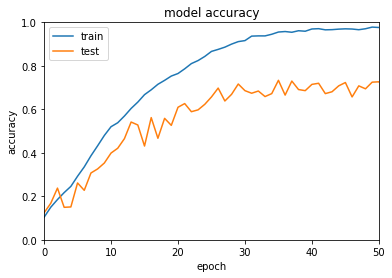

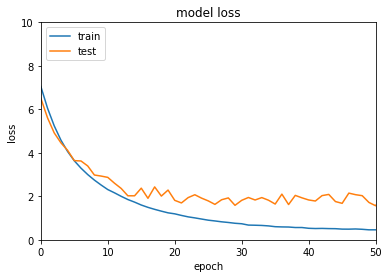

In [0]:
hist.history.keys()
history = hist
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.axis([0,50,0,1])
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.axis([0,50,0,10])
plt.show()

In [0]:
from keras.models import load_model
model1 = load_model('proposed_model_aug.h5')
model1.load_weights('proposed_crnn_aug.hdf5')

In [0]:
model_yaml = model1.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

In [0]:
y_pred = model1.predict_classes(X_test)

In [0]:
y_pred1 = []
for j in y_pred:
  vec = np.zeros(11)
  ind = np.where(j == np.amax(j))
  vec[ind] = 1.
  y_pred1.append(vec)
  
y_pred1 = np.array(y_pred1)

In [0]:
y_test1 = []
for j in Y_test:
  ind = np.where(j == np.amax(j))
  y_test1.append(ind[0][0])

y_test1 = np.array(y_test1)

In [0]:
import sklearn.metrics as skm

cm = skm.confusion_matrix(y_test1, y_pred)
print(cm)
print( skm.classification_report(y_test1,y_pred))

[[ 90   5   0   5   2   0   4   1   0   8   0]
 [  2 105   1   4   0   0   0   0   0   4   0]
 [  1   0  73  11   0   2  20   1   1   1   0]
 [  3   9   3 101   1   0   4   0   3   0   1]
 [  4   8   0   7  48   7   1   0   8   6   9]
 [  0   0   0   1   5  42   3   0   0   1   7]
 [  0   0   3   3   1   1 107   0   2   0   1]
 [  1   1   0   1   1   0   3  77   6   1   4]
 [  0   4   0   4   2   4   7  10  58   3  12]
 [  5   2   0   4   1   2   5   1   0  45  11]
 [  0   2   0   1   1   1   2   3   6  10  50]]
              precision    recall  f1-score   support

           0       0.85      0.78      0.81       115
           1       0.77      0.91      0.83       116
           2       0.91      0.66      0.77       110
           3       0.71      0.81      0.76       125
           4       0.77      0.49      0.60        98
           5       0.71      0.71      0.71        59
           6       0.69      0.91      0.78       118
           7       0.83      0.81      0.82      

In [0]:
print(get_class_names())

['org', 'voi', 'gac', 'gel', 'vio', 'cel', 'pia', 'tru', 'sax', 'flu', 'cla']


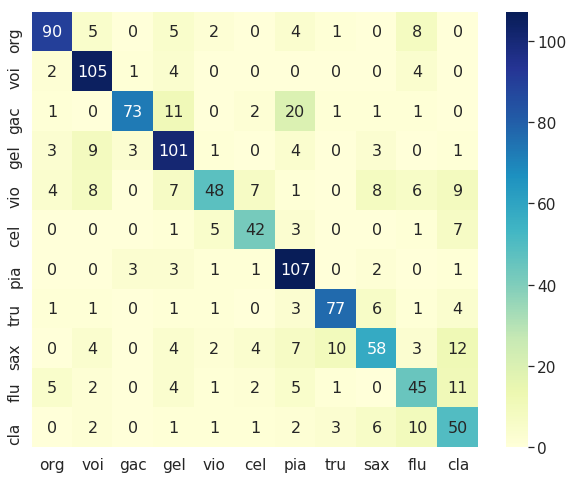

In [0]:
import seaborn as sn
import pandas as pd

df_cm = pd.DataFrame(cm)
sn.set(font_scale=1.4)
plt.subplots(figsize=(10,8))
ax = sn.heatmap(df_cm, annot=True,fmt="g",xticklabels=get_class_names(),yticklabels=get_class_names(),annot_kws={"size": 16},cmap="YlGnBu")